<h1><font size="6">Cataract Classification</font></h1>

In this notebook, uses two retina datasets to challenge the cataract classification.

## Contents
* [Import libraries](#import)
* [Set configurations and read metadata](#set)
* [Process Cataract dataset](#process1)
* [Process Ocular disease recognition dataset](#process2)
* [Create datasets](#create)
* [Build the model(1)](#build1)
* [Build the model(2)](#build2)

## Import libraries <a name="import"> </a>

In [4]:
!pip install -q efficientnet >> /dev/null

In [5]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

## Set configurations and read metadata <a name="set"> </a>

In [6]:
# SEED = 42
# EPOCHS = 100
# BATCH_SIZE = 32
# IMG_HEIGHT = 192
# IMG_WIDTH = 256

# # cataract dataset
# IMG_ROOT = '../input/cataractdataset/dataset/'
# IMG_DIR = [IMG_ROOT+'1_normal', 
#            IMG_ROOT+'2_cataract', 
#            IMG_ROOT+'2_glaucoma', 
#            IMG_ROOT+'3_retina_disease']

# # ocular-disease-recognition dataset
# OCU_IMG_ROOT = '../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/'
# ocu_df = pd.read_excel('../input/ocular-disease-recognition-odir5k/ODIR-5K/data.xlsx')
SEED = 42
EPOCHS = 50
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256

# cataract dataset
IMG_ROOT = '../input/mydata/'
IMG_DIR = [IMG_ROOT+'normal', 
           IMG_ROOT+'cataract'] 
           #IMG_ROOT+'2_glaucoma', 
           #IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
#OCU_IMG_ROOT = '../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/'
#ocu_df = pd.read_excel('../input/ocular-disease-recognition-odir5k/ODIR-5K/data.xlsx')

In [7]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

## Process Cataract dataset <a name="process1"> </a>

In [8]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(2800))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
   # elif filepath[0] == IMG_DIR[2]:  # glaucoma
    #    cat_df.iloc[i, 1] = 2
    #elif filepath[0] == IMG_DIR[3]:  # retine_disease
     #   cat_df.iloc[i, 1] = 3
        
# only sample normal and cataract        
cat_df = cat_df.query('0 <= cataract < 2')
cat_df[:20]

,paths,cataract
0,../input/mydata/normal/neg_original_neg_origin...,0
1,../input/mydata/normal/neg_original_neg_origin...,0
2,../input/mydata/normal/neg_original_Unknown-6....,0
3,../input/mydata/normal/neg_original_neg_origin...,0
4,../input/mydata/normal/neg_original_neg_origin...,0
5,../input/mydata/normal/neg_original_neg_origin...,0
6,../input/mydata/normal/neg_original_neg_origin...,0
7,../input/mydata/normal/neg_original_neg_origin...,0
8,../input/mydata/normal/neg_original_Unknown-5....,0
9,../input/mydata/normal/neg_original_images-8.j...,0


In [9]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
0    1400
1    1400
Name: cataract, dtype: int64


## Create datasets <a name="create"> </a>
Combine the two metadata and use them to load the image data and create datasets.

In [10]:
#df = pd.concat([cat_df, ocu_df], ignore_index=True)
df = cat_df
df.head()

,paths,cataract
0,../input/mydata/normal/neg_original_neg_origin...,0
1,../input/mydata/normal/neg_original_neg_origin...,0
2,../input/mydata/normal/neg_original_Unknown-6....,0
3,../input/mydata/normal/neg_original_neg_origin...,0
4,../input/mydata/normal/neg_original_neg_origin...,0


In [11]:
df.tail()

,paths,cataract
2795,../input/mydata/cataract/info_original_info_or...,1
2796,../input/mydata/cataract/info_original_info_or...,1
2797,../input/mydata/cataract/info_original_info_or...,1
2798,../input/mydata/cataract/info_original_info_or...,1
2799,../input/mydata/cataract/info_original_info_or...,1


In [12]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [13]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████| 560/560 [00:03<00:00, 180.70it/s]


In [ ]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

In [ ]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

## Build the model(1) <a name="build1"> </a>

In [14]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

In [49]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 256, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 256, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 256, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 85, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 85, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 85, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 85, 16)        2

Use some image data augmentation to generate randomly augmented image data from the ImageDataGenerator Object.

In [50]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/30
59/59 [==============================] - 27s 426ms/step - loss: 1.2045 - accuracy: 0.7075 - val_loss: 0.9426 - val_accuracy: 0.5000
Epoch 2/30
59/59 [==============================] - 20s 341ms/step - loss: 0.7147 - accuracy: 0.7868 - val_loss: 1.9187 - val_accuracy: 0.5000
Epoch 3/30
59/59 [==============================] - 21s 345ms/step - loss: 0.6764 - accuracy: 0.7920 - val_loss: 1.5829 - val_accuracy: 0.5000
Epoch 4/30
59/59 [==============================] - 21s 360ms/step - loss: 0.6149 - accuracy: 0.8146 - val_loss: 1.6743 - val_accuracy: 0.5060
Epoch 5/30
59/59 [==============================] - 20s 341ms/step - loss: 0.5191 - accuracy: 0.8472 - val_loss: 2.6694 - val_accuracy: 0.5119
Epoch 6/30
59/59 [==============================] - 21s 360ms/step - loss: 0.5549 - accuracy: 0.8214 - val_loss: 2.8313 - val_accuracy: 0.5000
Epoch 7/30
59/59 [==============================] - 21s 351ms/step - loss: 0.4965 - accuracy: 0.8519 - val_loss: 1.7577 - val_accuracy: 0.5417

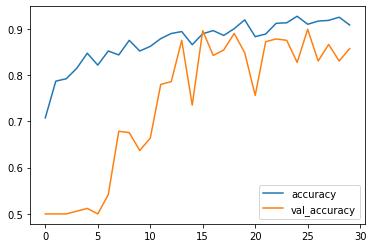

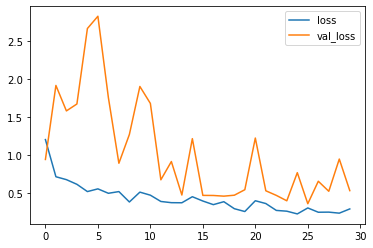

In [51]:

EPOCHS=30
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [52]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

Epoch 1/30
59/59 [==============================] - 22s 369ms/step - loss: 0.2181 - accuracy: 0.9280 - val_loss: 0.4459 - val_accuracy: 0.8839
Epoch 2/30
18/59 [========>.....................] - ETA: 16s - loss: 0.1948 - accuracy: 0.9464

KeyboardInterrupt: 

In [53]:
train_score = model.evaluate(train_imgs, train_df)
val_score = model.evaluate(test_imgs, test_df)
test_score = model.evaluate(val_imgs, val_df)

print("Train Accuracy: {:.2f}%".format(train_score[1] * 100))
print("Validation Accuracy: {:.2f}%".format(val_score[1] * 100))
print("Test Accuracy: {:.2f}%".format(test_score[1] * 100))

2022-08-13 13:40:56.647019: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1123024896 exceeds 10% of free system memory.
2022-08-13 13:40:58.314047: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1123024896 exceeds 10% of free system memory.


11/11 [==============================] - 0s 19ms/step - loss: 1.0769 - accuracy: 0.7738
Train Accuracy: 78.05%
Validation Accuracy: 79.11%
Test Accuracy: 77.38%


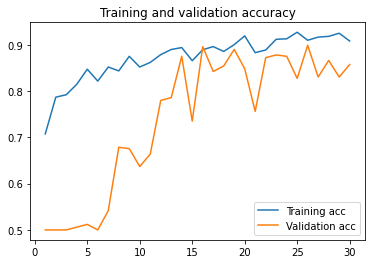

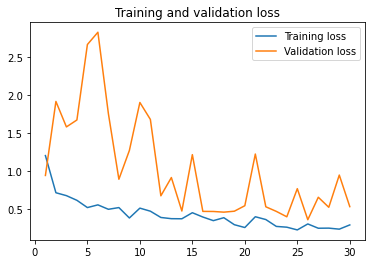

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc,  label='Training acc')
plt.plot(epochs, val_acc,  label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.legend()

plt.show()

In [55]:
model.save_weights("modelcnn.h5")
model.save("cnnmodel.h5")
print("Saved model to disk")

Saved model to disk


In [56]:
pred_prob = model.predict(test_imgs[:9])
pred_class=np.argmax(pred_prob,axis=1)
print("for nine instances \n\n pred-probabilities : \n\n", pred_prob[:9],"\n predicted_Class :\n\n",pred_class[:9])



for nine instances 

 pred-probabilities : 

 [[2.7421843e-03 9.9725789e-01]
 [1.2629843e-01 8.7370157e-01]
 [9.9691951e-01 3.0805040e-03]
 [9.9959320e-01 4.0679463e-04]
 [4.4056159e-04 9.9955946e-01]
 [9.9844033e-01 1.5596510e-03]
 [4.4264160e-02 9.5573580e-01]
 [5.7305664e-01 4.2694339e-01]
 [1.0202745e-10 1.0000000e+00]] 
 predicted_Class :

 [1 1 0 0 1 0 1 0 1]


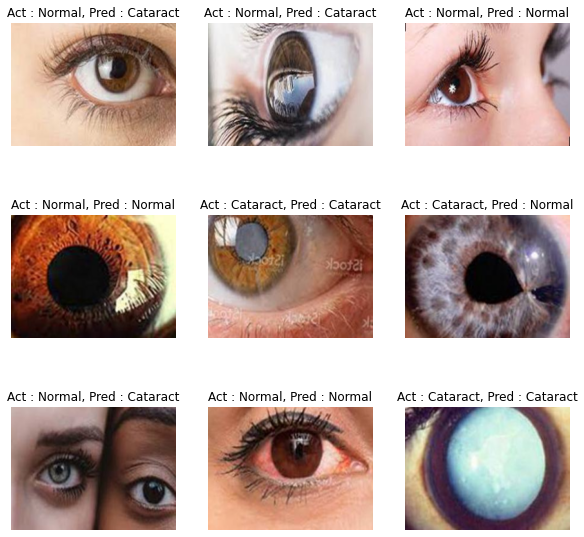

In [58]:

# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(3, 3, figsize=(10,10))
norm_list = list(test_df[0][:9])
for i, img in enumerate(test_imgs[:9]):
    ax[i//3, i%3].imshow(img)
    ax[i//3, i%3].axis('off')
    if norm_list[i] == 1 and pred_class[i]==0:
        ax[i//3, i%3].set_title('Act : Normal, Pred : Normal')
    elif norm_list[i] == 1 and pred_class[i]==1:
        ax[i//3, i%3].set_title('Act : Normal, Pred : Cataract')
    elif norm_list[i] == 0 and pred_class[i]==0:
        ax[i//3, i%3].set_title('Act : Cataract, Pred : Normal')
    elif norm_list[i] == 0 and pred_class[i]==1:
        ax[i//3, i%3].set_title('Act : Cataract, Pred : Cataract')
        
plt.show()

## Build the model(2) <a name="build2"> </a>
We will train using a model that has been pre-trained.

In [15]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

2022-08-13 12:44:35.234683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 12:44:35.394006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 12:44:35.399512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-13 12:44:35.407025: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

16818176/16804768 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 6, 8, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [16]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

2022-08-13 12:44:43.412194: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-08-13 12:44:54.914091: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


59/59 [==============================] - 47s 489ms/step - loss: 0.6734 - accuracy: 0.5888 - val_loss: 0.6312 - val_accuracy: 0.6726
Epoch 2/30
59/59 [==============================] - 26s 441ms/step - loss: 0.6194 - accuracy: 0.6775 - val_loss: 0.6113 - val_accuracy: 0.6726
Epoch 3/30
59/59 [==============================] - 26s 433ms/step - loss: 0.5640 - accuracy: 0.7500 - val_loss: 0.5888 - val_accuracy: 0.6964
Epoch 4/30
59/59 [==============================] - 26s 443ms/step - loss: 0.5173 - accuracy: 0.8193 - val_loss: 0.5612 - val_accuracy: 0.7649
Epoch 5/30
59/59 [==============================] - 27s 444ms/step - loss: 0.4865 - accuracy: 0.8367 - val_loss: 0.5312 - val_accuracy: 0.7738
Epoch 6/30
59/59 [==============================] - 26s 440ms/step - loss: 0.4449 - accuracy: 0.8661 - val_loss: 0.4916 - val_accuracy: 0.8185
Epoch 7/30
59/59 [==============================] - 25s 427ms/step - loss: 0.4147 - accuracy: 0.8866 - val_loss: 0.4346 - val_accuracy: 0.8571
Epoch 8/30

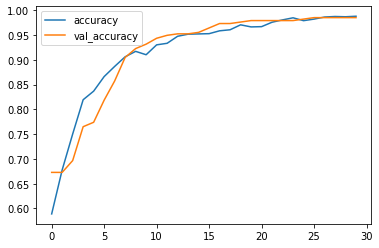

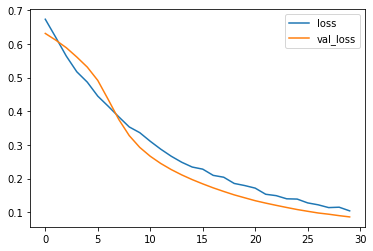

In [17]:
EPOCHS=30
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [18]:
model.evaluate(test_imgs, test_df) 

18/18 [==============================] - 1s 42ms/step - loss: 0.0887 - accuracy: 0.9857


[0.08868458122015, 0.9857142567634583]

In [19]:
train_score = model.evaluate(train_imgs, train_df)
val_score = model.evaluate(test_imgs, test_df)
test_score = model.evaluate(val_imgs, val_df)

print("Train Accuracy: {:.2f}%".format(train_score[1] * 100))
print("Validation Accuracy: {:.2f}%".format(val_score[1] * 100))
print("Test Accuracy: {:.2f}%".format(test_score[1] * 100))

2022-08-13 12:59:20.768945: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1123024896 exceeds 10% of free system memory.
2022-08-13 12:59:23.055443: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1123024896 exceeds 10% of free system memory.


11/11 [==============================] - 0s 40ms/step - loss: 0.0859 - accuracy: 0.9851
Train Accuracy: 99.47%
Validation Accuracy: 98.57%
Test Accuracy: 98.51%


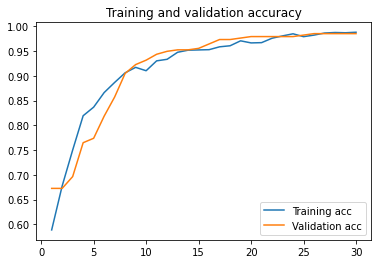

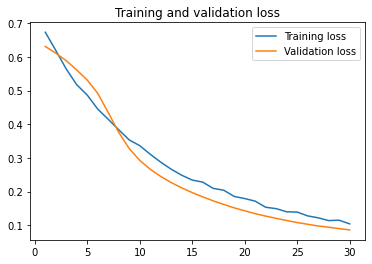

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc,  label='Training acc')
plt.plot(epochs, val_acc,  label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.legend()

plt.show()

In [48]:
model.save_weights("modeleff.h5")
model.save("effmodel.h5")
print("Saved model to disk")

In [ ]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

In [25]:
test_imgs[1]

array([[[0.8       , 0.8039216 , 0.78039217],
        [0.83137256, 0.8352941 , 0.8117647 ],
        [0.8627451 , 0.8666667 , 0.84705883],
        ...,
        [0.89411765, 0.8627451 , 0.85490197],
        [0.8901961 , 0.85882354, 0.8509804 ],
        [0.8901961 , 0.85882354, 0.8509804 ]],

       [[0.8       , 0.8039216 , 0.78039217],
        [0.83137256, 0.8352941 , 0.8117647 ],
        [0.8627451 , 0.8666667 , 0.84705883],
        ...,
        [0.89411765, 0.85882354, 0.8509804 ],
        [0.8901961 , 0.85882354, 0.8509804 ],
        [0.8901961 , 0.85882354, 0.8509804 ]],

       [[0.79607844, 0.8       , 0.7764706 ],
        [0.827451  , 0.83137256, 0.8117647 ],
        [0.8627451 , 0.8666667 , 0.84705883],
        ...,
        [0.8901961 , 0.85882354, 0.8509804 ],
        [0.8901961 , 0.85882354, 0.8509804 ],
        [0.8862745 , 0.85490197, 0.84705883]],

       ...,

       [[0.3882353 , 0.38431373, 0.40392157],
        [0.38039216, 0.3764706 , 0.39215687],
        [0.3647059 , 0

In [39]:
pred_prob = model.predict(test_imgs[:9])
pred_class=np.argmax(pred_prob,axis=1)
print("for nine instances \n\n pred-probabilities : \n\n", pred_prob[:9],"\n predicted_Class :\n\n",pred_class[:9])

for nine instances 

 pred-probabilities : 

 [[0.99019825 0.00980172]
 [0.96790534 0.03209465]
 [0.99490005 0.00509994]
 [0.9677805  0.03221949]
 [0.05903256 0.94096744]
 [0.5376398  0.4623602 ]
 [0.9879104  0.01208954]
 [0.9754919  0.02450807]
 [0.01732078 0.98267925]] 
 predicted_Class :

 [0 0 0 0 1 0 0 0 1]


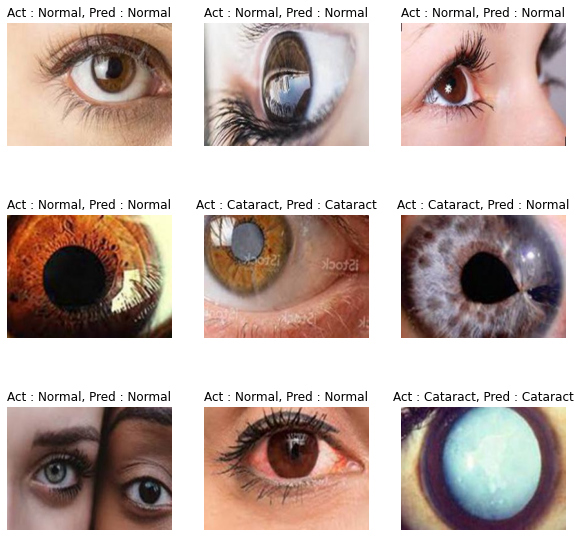

In [46]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(3, 3, figsize=(10,10))
norm_list = list(test_df[0][:9])
for i, img in enumerate(test_imgs[:9]):
    ax[i//3, i%3].imshow(img)
    ax[i//3, i%3].axis('off')
    if norm_list[i] == 1 and pred_class[i]==0:
        ax[i//3, i%3].set_title('Act : Normal, Pred : Normal')
    elif norm_list[i] == 1 and pred_class[i]==1:
        ax[i//3, i%3].set_title('Act : Normal, Pred : Cataract')
    elif norm_list[i] == 0 and pred_class[i]==0:
        ax[i//3, i%3].set_title('Act : Cataract, Pred : Normal')
    else:
        ax[i//3, i%3].set_title('Act : Cataract, Pred : Cataract')
        
plt.show()

In [ ]:
model.save_weights("modelcnn.h5")
model.save("cnnmodel.h5")
print("Saved model to disk")

pred_prob = model.predict(test_imgs[:9])
pred_class=np.argmax(pred_prob,axis=1)
print("for nine instances \n\n pred-probabilities : \n\n", pred_prob[:9],"\n predicted_Class :\n\n",pred_class[:9])

# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(3, 3, figsize=(10,10))
norm_list = list(test_df[0][:9])
for i, img in enumerate(test_imgs[:9]):
    ax[i//3, i%3].imshow(img)
    ax[i//3, i%3].axis('off')
    if norm_list[i] == 1 and pred_class[i]==0:
        ax[i//3, i%3].set_title('Act : Normal, Pred : Normal')
    elif norm_list[i] == 1 and pred_class[i]==1:
        ax[i//3, i%3].set_title('Act : Normal, Pred : Cataract')
    elif norm_list[i] == 0 and pred_class[i]==0:
        ax[i//3, i%3].set_title('Act : Cataract, Pred : Normal')
    else:
        ax[i//3, i%3].set_title('Act : Cataract, Pred : Cataract')
        
plt.show()